In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix as sk_confusion_matrix, classification_report

# CNN definition
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x





In [15]:
# train
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    accuracy = 100. * correct / total
    avg_loss = running_loss / len(train_loader)
    print(f'\nTraining - Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%\n')

In [16]:
# metrics
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss, correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            correct += preds.eq(target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test - Avg Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%\n')

    return accuracy, np.array(all_preds), np.array(all_labels)

Using device: cuda
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

Total parameters: 390410
Epoch: 1 [0/60000 (0%)]	Loss: 2.315253
Epoch: 1 [6400/60000 (11%)]	Loss: 0.145885
Epoch: 1 [12800/60000 (21%)]	Loss: 0.220483
Epoch: 1 [19200/60000 (32%)]	Loss: 0.259873
Epoch: 1 [25600/60000 (43%)]	Loss: 0.096928
Epoch: 1 [32000/60000 (53%)]	Loss: 0.073987
Epoch: 1 [38400/60000 (64%)]	Loss: 0.186996
Epoch: 1 [44800/60000 (75%)]	Loss: 0.060123
Epoch: 1 [51200/60000 (85%)]	Loss: 0.038006
Epoch: 1 [57600/60000 (96%)]	Loss: 0.078983

Training - Av

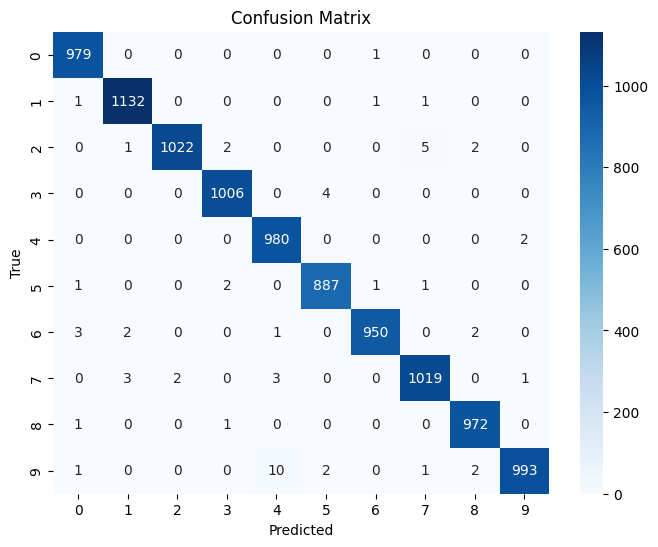


Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      1.00       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



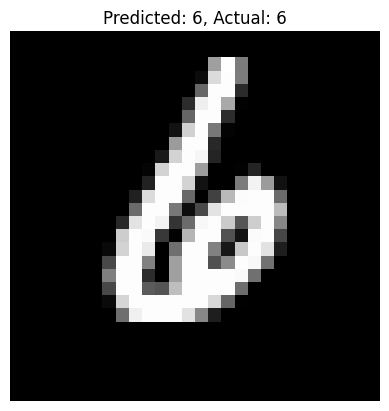

In [17]:
# random visualization
def visualize_random_prediction(model, device, test_dataset, transform):
    model.eval()
    idx = random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[idx]

    with torch.no_grad():
        input_img = image.unsqueeze(0).to(device)
        output = model(input_img)
        pred = output.argmax(dim=1).item()

    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Predicted: {pred}, Actual: {label}')
    plt.axis('off')
    plt.show()


# confusion amtrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = sk_confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=classes))


# Main execution
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    batch_size = 64
    learning_rate = 0.001
    num_epochs = 10

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = CNN(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(model)
    print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters())}')

    for epoch in range(1, num_epochs + 1):
        train(model, device, train_loader, optimizer, criterion, epoch)
        test(model, device, test_loader, criterion)

    torch.save(model.state_dict(), '/content/cnn_model.pth')
    print('Model saved to cnn_model.pth')


    _, preds, labels = test(model, device, test_loader, criterion)
    plot_confusion_matrix(labels, preds, classes=[str(i) for i in range(10)])


    visualize_random_prediction(model, device, test_dataset, transform)